In [1]:
import json
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set the directory path
data_dir = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work"

def load_annotation_data():
    """Load all annotation JSON files"""
    # Load all 4 JSON files and display expert names properly
    json_files = {
        'Expert A': 'alexa_annotations.json',
        'Expert K': 'katrin_annotations.json', 
        'Expert L': 'luisa_annotations.json',
        'Expert M': 'martin_annotations.json'
    }
    
    expert_data = {}
    
    for expert, filename in json_files.items():
        file_path = os.path.join(data_dir, filename)
        
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        expert_data[expert] = data
        print(f"Loaded {len(data)} annotations for {expert}")
    
    return expert_data

def get_iaa_images_by_expert(expert_data):
    """Extract IAA images annotated by each expert with their annotations"""
    expert_iaa_images = {}
    expert_annotations = {}
    
    for expert, data in expert_data.items():
        iaa_images = []
        annotations_dict = {}
        
        for record in data:
            filename = record['data']['original_filename']
            if '_IAA' in filename:
                iaa_images.append(filename)
                
                # Extract annotation scores from the result
                if record['annotations'] and len(record['annotations']) > 0:
                    annotation = record['annotations'][0]['result']
                    annotations_dict[filename] = extract_scores_from_annotation(annotation)
        
        expert_iaa_images[expert] = set(iaa_images)
        expert_annotations[expert] = annotations_dict
        print(f"{expert}: {len(iaa_images)} IAA images with annotations")
    
    return expert_iaa_images, expert_annotations

def extract_scores_from_annotation(annotation_result):
    """Extract numerical scores from Label Studio annotation result"""
    scores = {}
    
    # Correct mapping based on your actual Label Studio field names
    field_mapping = {
        'img_simplicity': 'image_simplicity',
        'img_quality': 'image_quality', 
        'txt_simplicity': 'text_simplicity',
        'txt_quality': 'text_quality',
        'ethics': 'ethics',
        'txt_img_align': 'text_image_alignment'
    }
    
    # Also extract other annotation data for later analysis
    additional_data = {}
    
    for item in annotation_result:
        if item.get('type') == 'number':
            from_name = item.get('from_name')
            value = item.get('value', {}).get('number')
            
            # Map to our standardized field names
            if from_name in field_mapping and value is not None:
                scores[field_mapping[from_name]] = value
        
        elif item.get('type') == 'choices':
            from_name = item.get('from_name')
            choices = item.get('value', {}).get('choices', [])
            
            # Store choice-based annotations for later analysis
            if from_name in ['no_text', 'well_separated_obj']:
                additional_data[from_name] = choices
            elif from_name == 'image_style':
                additional_data['styles'] = choices
            elif from_name == 'concerns':
                additional_data['concerns'] = choices
    
    # Add additional data to scores for completeness
    scores['additional_data'] = additional_data
    
    return scores

def find_iaa_intersections(expert_iaa_images):
    """Find intersections between experts for IAA images"""
    
    # Find intersection of all experts (images annotated by ALL 4 experts)
    intersection_all = expert_iaa_images['Expert A']
    for expert in ['Expert K', 'Expert L', 'Expert M']:
        intersection_all = intersection_all.intersection(expert_iaa_images[expert])
    
    # Find images annotated by at least 2 experts
    image_count = defaultdict(list)
    for expert, images in expert_iaa_images.items():
        for image in images:
            image_count[image].append(expert)
    
    # Group by number of experts who annotated each image
    by_expert_count = defaultdict(list)
    for image, experts_who_annotated in image_count.items():
        count = len(experts_who_annotated)
        by_expert_count[count].append((image, experts_who_annotated))
    
    # Create the three categories
    images_4_experts = intersection_all
    images_3plus_experts = set()
    images_2plus_experts = set()
    
    for count in [4, 3]:
        for image, _ in by_expert_count.get(count, []):
            images_3plus_experts.add(image)
    
    for count in [4, 3, 2]:
        for image, _ in by_expert_count.get(count, []):
            images_2plus_experts.add(image)
    
    return {
        '4_experts': images_4_experts,
        '3plus_experts': images_3plus_experts, 
        '2plus_experts': images_2plus_experts
    }, image_count

def prepare_scores_for_kappa(image_set, expert_annotations, image_expert_mapping):
    """Prepare score matrices for Cohen's Kappa calculation"""
    
    # Define score dimensions
    dimensions = ['image_simplicity', 'image_quality', 'text_simplicity', 
                  'text_quality', 'ethics', 'text_image_alignment']
    
    expert_scores = {dim: defaultdict(dict) for dim in dimensions}
    
    # Extract scores for images in the set
    for image in image_set:
        experts_for_image = image_expert_mapping.get(image, [])
        
        for expert in experts_for_image:
            if image in expert_annotations[expert]:
                annotation = expert_annotations[expert][image]
                
                for dim in dimensions:
                    if dim in annotation:
                        expert_scores[dim][image][expert] = annotation[dim]
    
    return expert_scores

def calculate_cohens_kappa_pairwise(expert_scores, category_name):
    """Calculate Cohen's Kappa for all expert pairs across all dimensions"""
    
    dimensions = list(expert_scores.keys())
    experts = ['Expert A', 'Expert K', 'Expert L', 'Expert M']
    expert_pairs = list(combinations(experts, 2))
    
    results = {}
    
    print(f"\n{'='*60}")
    print(f"COHEN'S KAPPA ANALYSIS - {category_name.upper()}")
    print(f"{'='*60}")
    
    for dim in dimensions:
        print(f"\n--- {dim.replace('_', ' ').title()} ---")
        results[dim] = {}
        
        kappa_scores = []
        
        expert_pairs = [('Expert A', 'Expert K'), ('Expert A', 'Expert L'), 
                       ('Expert A', 'Expert M'), ('Expert K', 'Expert L'),
                       ('Expert K', 'Expert M'), ('Expert L', 'Expert M')]
        
        for expert1, expert2 in expert_pairs:
            pair_name = f"{expert1}_vs_{expert2}"
            
            # Find common images rated by both experts
            images_expert1 = set(expert_scores[dim].keys())
            images_expert2 = set(expert_scores[dim].keys())
            
            common_images = []
            scores_expert1 = []
            scores_expert2 = []
            
            for image in images_expert1:
                if (expert1 in expert_scores[dim][image] and 
                    expert2 in expert_scores[dim][image]):
                    common_images.append(image)
                    scores_expert1.append(expert_scores[dim][image][expert1])
                    scores_expert2.append(expert_scores[dim][image][expert2])
            
            if len(common_images) >= 2:  # Need at least 2 common ratings
                kappa = cohen_kappa_score(scores_expert1, scores_expert2)
                results[dim][pair_name] = {
                    'kappa': kappa,
                    'n_images': len(common_images),
                    'common_images': common_images
                }
                kappa_scores.append(kappa)
                
                print(f"  {expert1} vs {expert2}: "
                      f"κ = {kappa:.3f} (n={len(common_images)})")
            else:
                results[dim][pair_name] = {
                    'kappa': None,
                    'n_images': len(common_images),
                    'common_images': common_images
                }
                print(f"  {expert1} vs {expert2}: "
                      f"Insufficient data (n={len(common_images)})")
        
        # Calculate average kappa for this dimension
        if kappa_scores:
            avg_kappa = np.mean(kappa_scores)
            results[dim]['average_kappa'] = avg_kappa
            print(f"  Average κ: {avg_kappa:.3f}")
        else:
            results[dim]['average_kappa'] = None
            print(f"  Average κ: No valid pairs")
    
    return results

def interpret_kappa_scores(kappa_value):
    """Interpret Cohen's Kappa values according to Landis & Koch (1977)"""
    if kappa_value is None:
        return "No data"
    elif kappa_value < 0:
        return "Poor (worse than chance)"
    elif kappa_value < 0.20:
        return "Slight"
    elif kappa_value < 0.40:
        return "Fair"
    elif kappa_value < 0.60:
        return "Moderate"
    elif kappa_value < 0.80:
        return "Substantial"
    else:
        return "Almost perfect"

def create_kappa_summary_table(all_results):
    """Create a summary table of all Cohen's Kappa results"""
    
    dimensions = ['image_simplicity', 'image_quality', 'text_simplicity', 
                  'text_quality', 'ethics', 'text_image_alignment']
    categories = ['4_experts', '3plus_experts', '2plus_experts']
    
    print(f"\n{'='*80}")
    print("COHEN'S KAPPA SUMMARY TABLE")
    print(f"{'='*80}")
    
    # Create summary DataFrame
    summary_data = []
    
    for category in categories:
        if category in all_results:
            for dim in dimensions:
                if dim in all_results[category]:
                    avg_kappa = all_results[category][dim].get('average_kappa')
                    if avg_kappa is not None:
                        interpretation = interpret_kappa_scores(avg_kappa)
                        summary_data.append({
                            'Category': category.replace('_', ' ').title(),
                            'Dimension': dim.replace('_', ' ').title(),
                            'Average Kappa': f"{avg_kappa:.3f}",
                            'Interpretation': interpretation
                        })
    
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        
        # Calculate overall statistics
        print(f"\n{'='*40}")
        print("OVERALL STATISTICS")
        print(f"{'='*40}")
        
        for category in categories:
            if category in all_results:
                kappa_values = []
                for dim in dimensions:
                    if (dim in all_results[category] and 
                        all_results[category][dim].get('average_kappa') is not None):
                        kappa_values.append(all_results[category][dim]['average_kappa'])
                
                if kappa_values:
                    overall_avg = np.mean(kappa_values)
                    overall_std = np.std(kappa_values)
                    print(f"{category.replace('_', ' ').title()}:")
                    print(f"  Overall Average κ: {overall_avg:.3f} ± {overall_std:.3f}")
                    print(f"  Interpretation: {interpret_kappa_scores(overall_avg)}")
                    print(f"  Valid dimensions: {len(kappa_values)}/{len(dimensions)}")
    
    return summary_data

def main():
    """Main analysis function"""
    
    print("Loading annotation data...")
    expert_data = load_annotation_data()
    
    print("\nExtracting IAA images and annotations...")
    expert_iaa_images, expert_annotations = get_iaa_images_by_expert(expert_data)
    
    print("\nFinding IAA intersections...")
    iaa_categories, image_expert_mapping = find_iaa_intersections(expert_iaa_images)
    
    print(f"\nIAA Categories Found:")
    for category, images in iaa_categories.items():
        print(f"  {category.replace('_', ' ').title()}: {len(images)} images")
    
    # Calculate Cohen's Kappa for each category
    all_results = {}
    
    for category_key, image_set in iaa_categories.items():
        if len(image_set) > 0:
            category_name = category_key.replace('_', ' ')
            
            # Prepare score matrices
            expert_scores = prepare_scores_for_kappa(
                image_set, expert_annotations, image_expert_mapping
            )
            
            # Calculate Cohen's Kappa
            results = calculate_cohens_kappa_pairwise(expert_scores, category_name)
            all_results[category_key] = results
    
    # Create summary table
    create_kappa_summary_table(all_results)
    
    return all_results, expert_annotations, iaa_categories

if __name__ == "__main__":
    # Run the complete IAA analysis
    results, annotations, categories = main()
    
    print(f"\n{'='*60}")
    print("ANALYSIS COMPLETE!")
    print("Results saved in 'results' variable")
    print("Annotations data saved in 'annotations' variable") 
    print("IAA categories saved in 'categories' variable")
    print(f"{'='*60}")

Loading annotation data...
Loaded 250 annotations for Expert A
Loaded 250 annotations for Expert K
Loaded 200 annotations for Expert L
Loaded 276 annotations for Expert M

Extracting IAA images and annotations...
Expert A: 71 IAA images with annotations
Expert K: 81 IAA images with annotations
Expert L: 61 IAA images with annotations
Expert M: 84 IAA images with annotations

Finding IAA intersections...

IAA Categories Found:
  4 Experts: 19 images
  3Plus Experts: 30 images
  2Plus Experts: 113 images

COHEN'S KAPPA ANALYSIS - 4 EXPERTS

--- Image Simplicity ---
  Expert A vs Expert K: κ = 0.095 (n=19)
  Expert A vs Expert L: κ = 0.104 (n=19)
  Expert A vs Expert M: κ = 0.012 (n=19)
  Expert K vs Expert L: κ = 0.131 (n=19)
  Expert K vs Expert M: κ = 0.084 (n=19)
  Expert L vs Expert M: κ = 0.015 (n=19)
  Average κ: 0.074

--- Image Quality ---
  Expert A vs Expert K: κ = 0.109 (n=19)
  Expert A vs Expert L: κ = 0.018 (n=19)
  Expert A vs Expert M: κ = 0.034 (n=19)
  Expert K vs Exper

Creating Cohen's Kappa visualizations...
1. Creating summary heatmap...


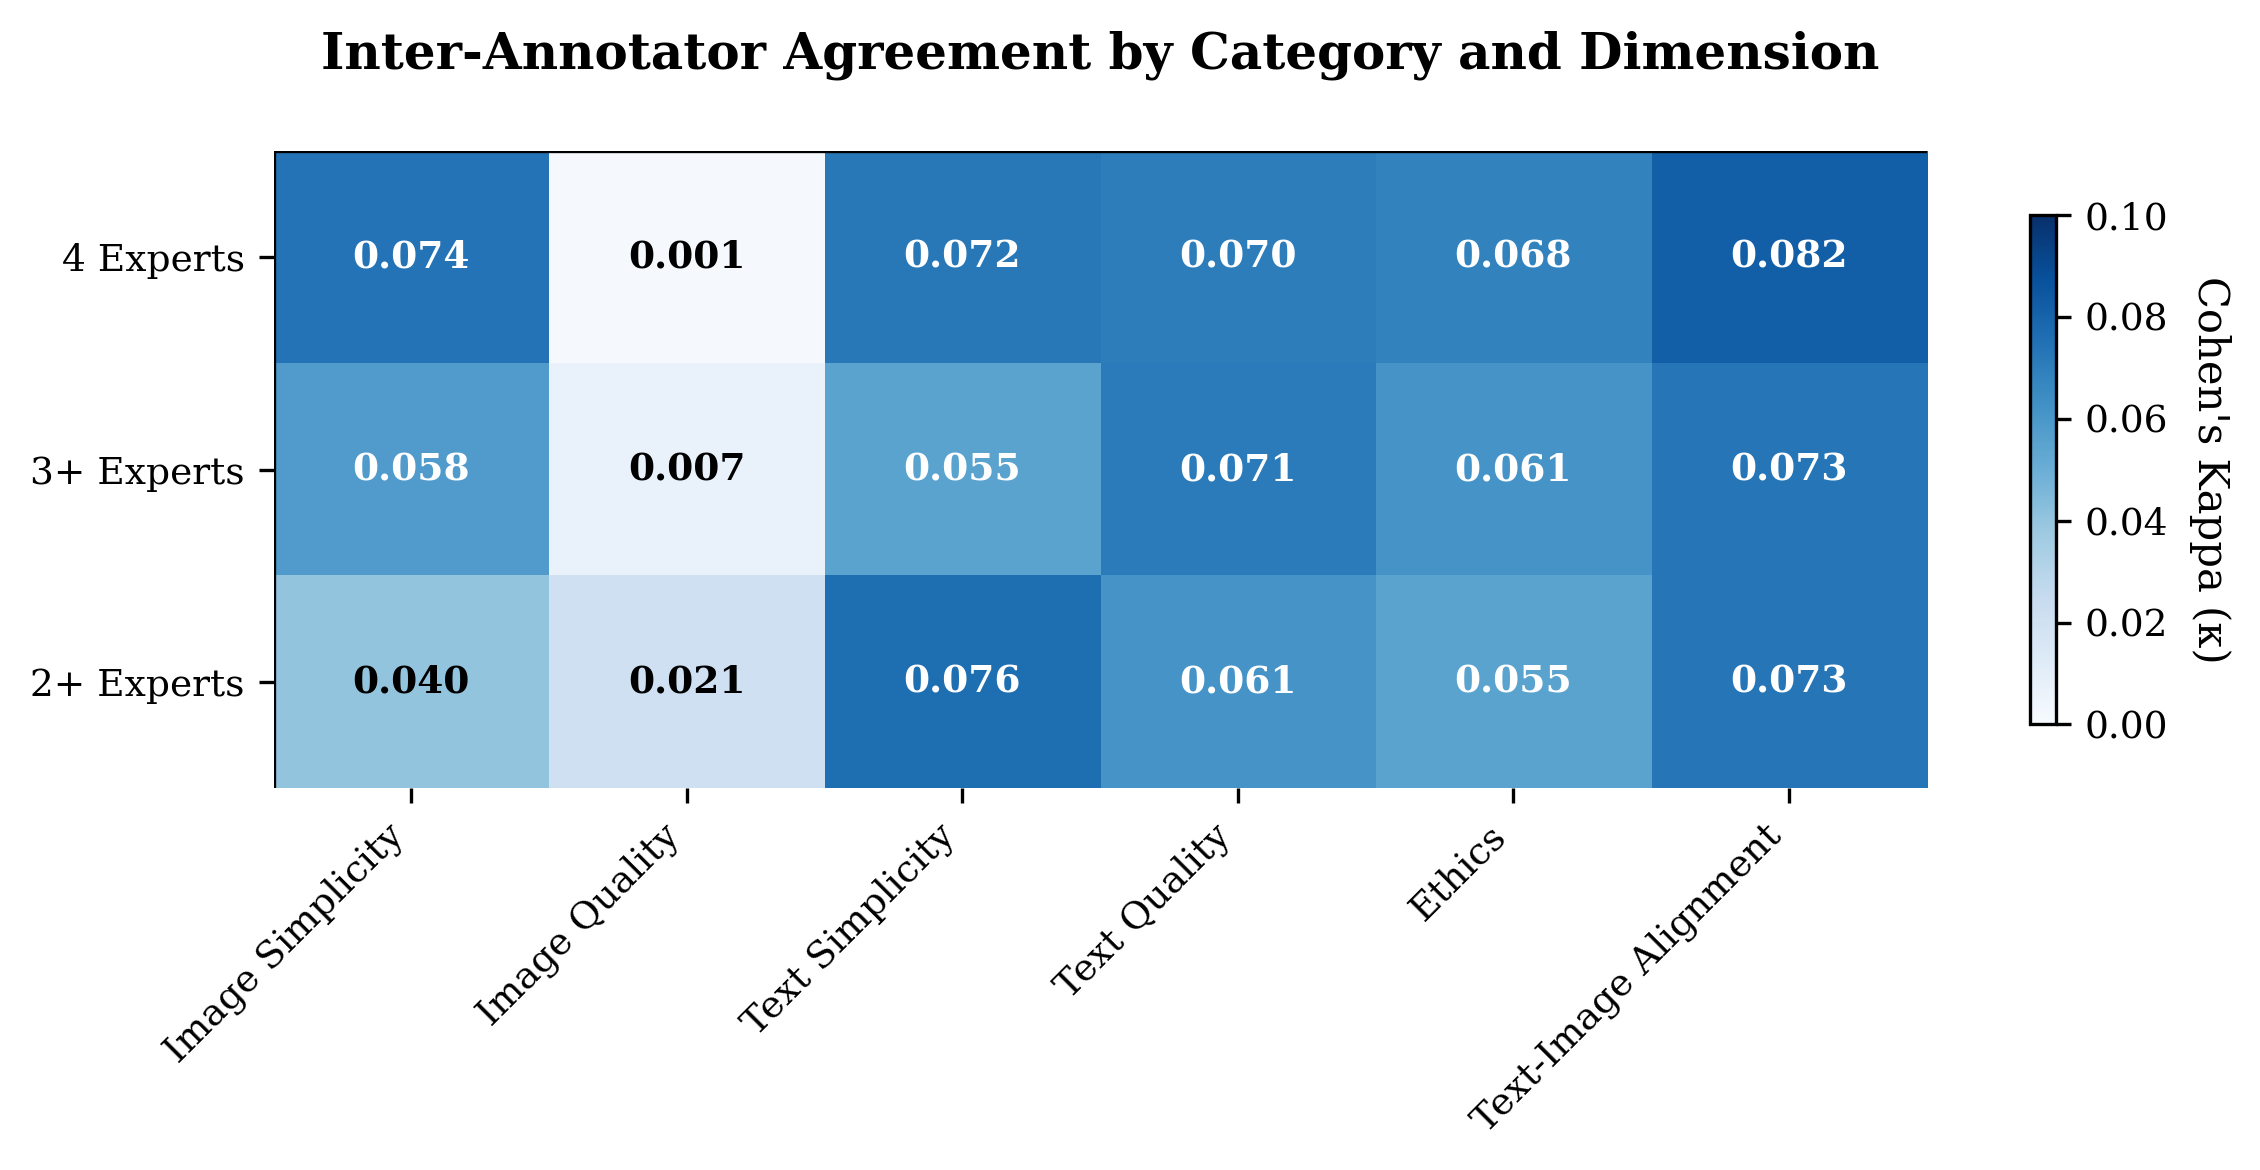

2. Creating grouped bar chart...


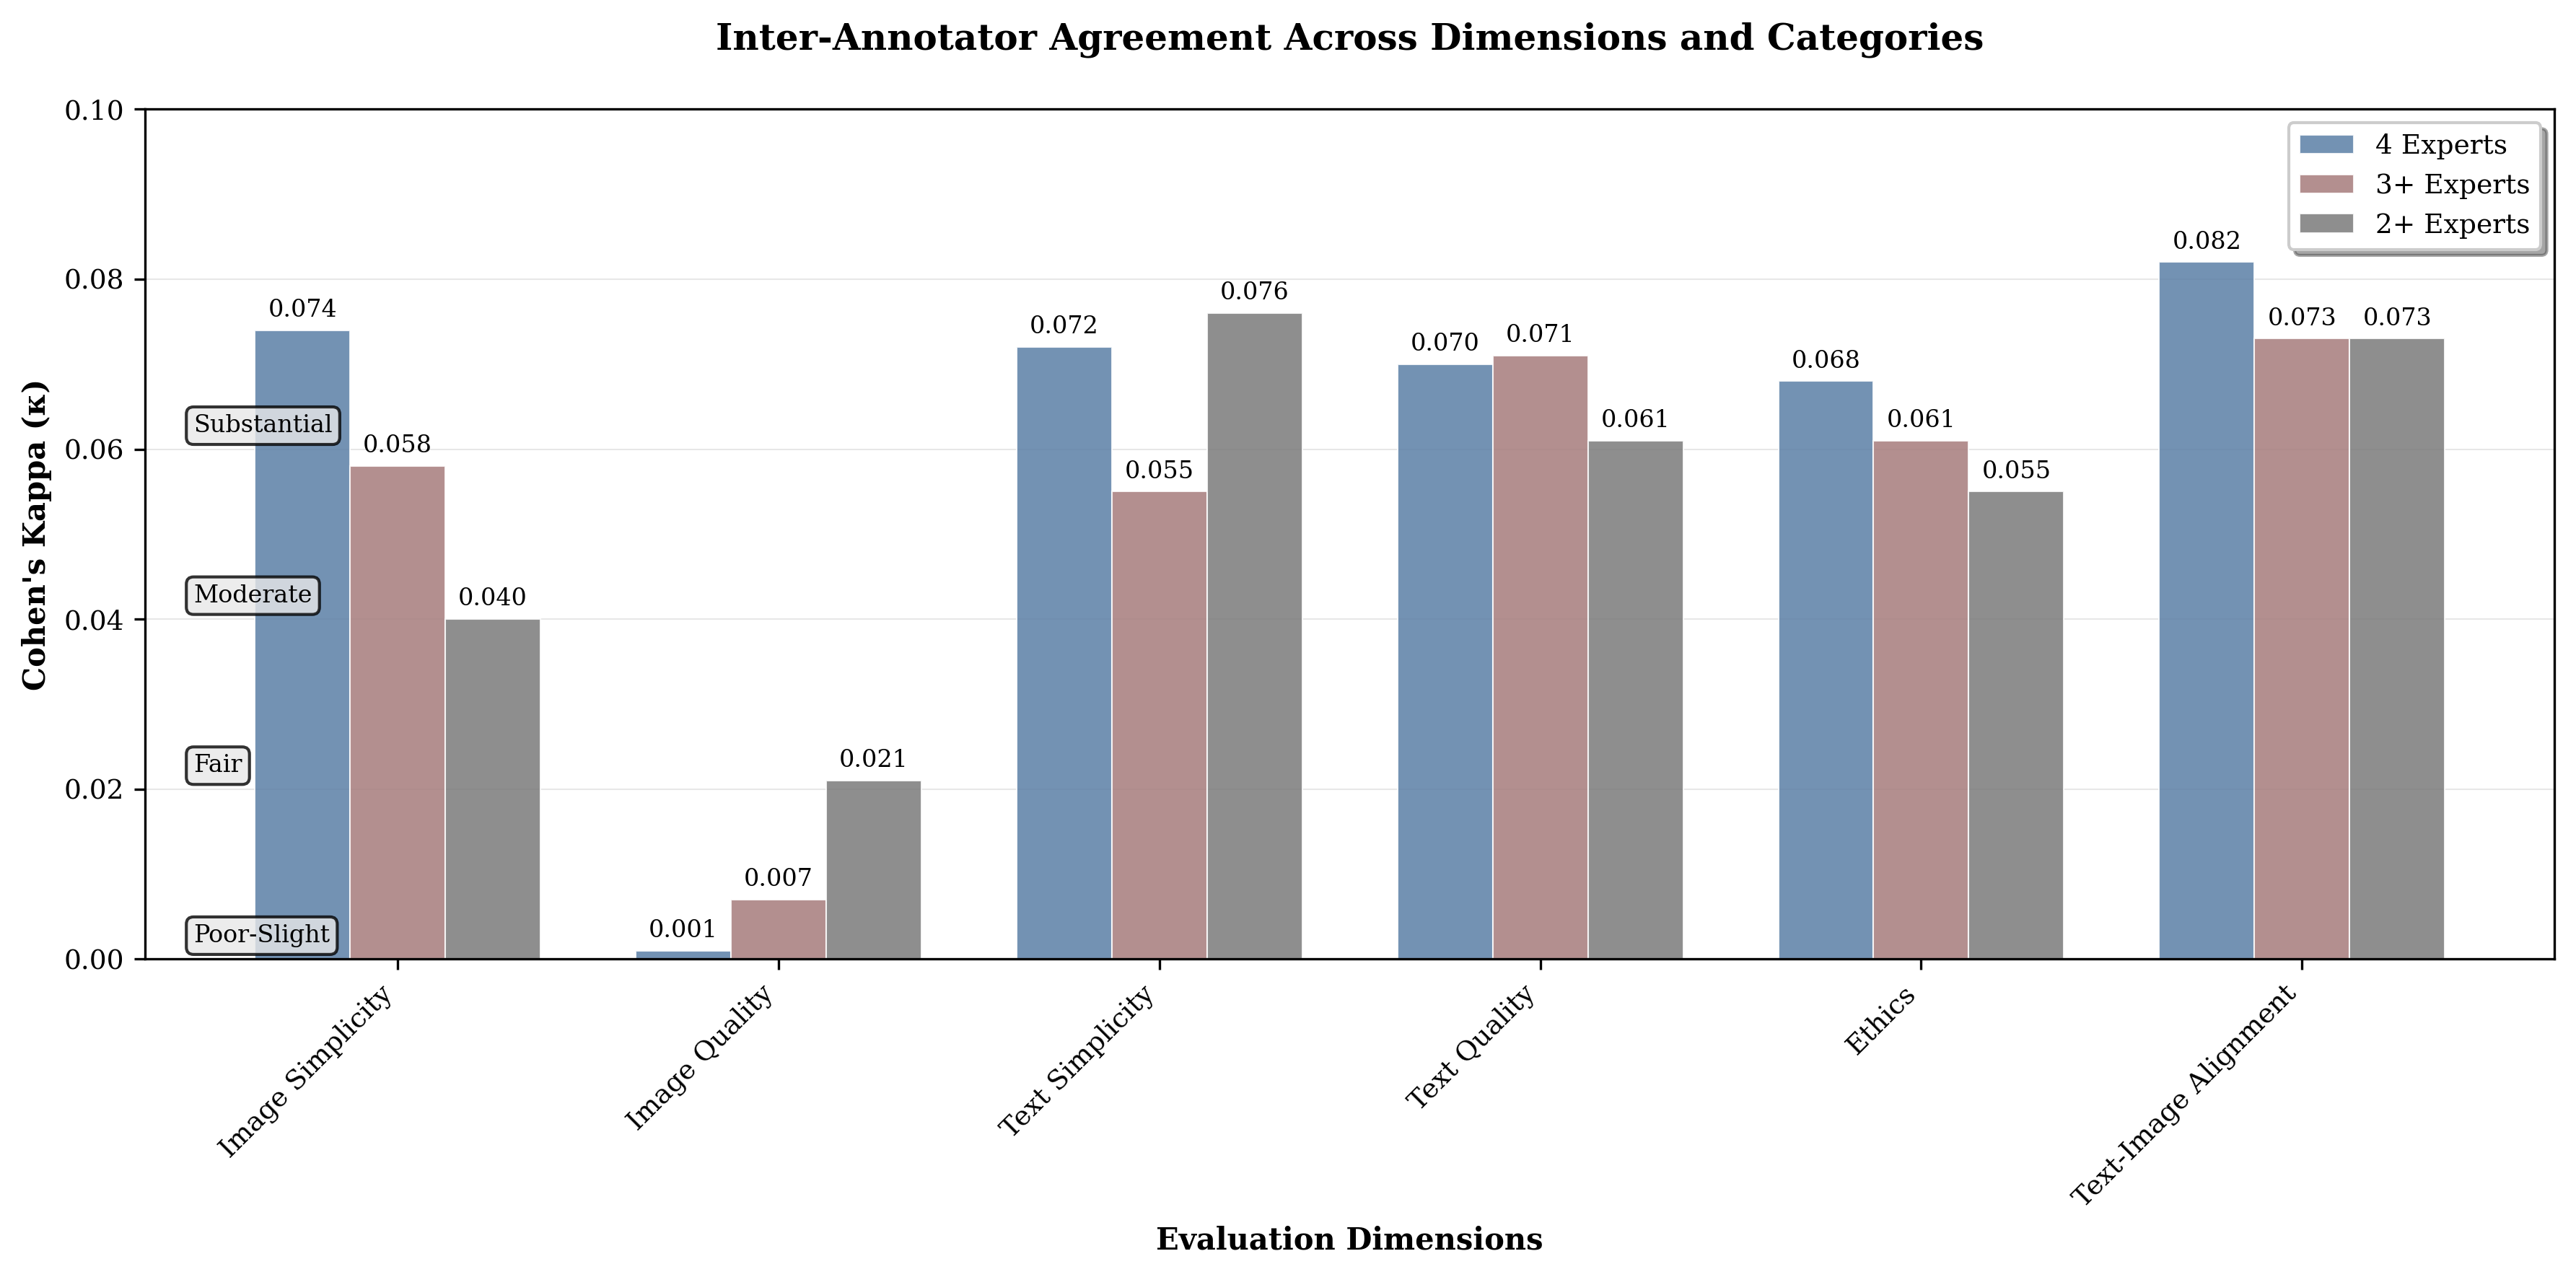

3. Creating expert pair heatmap...


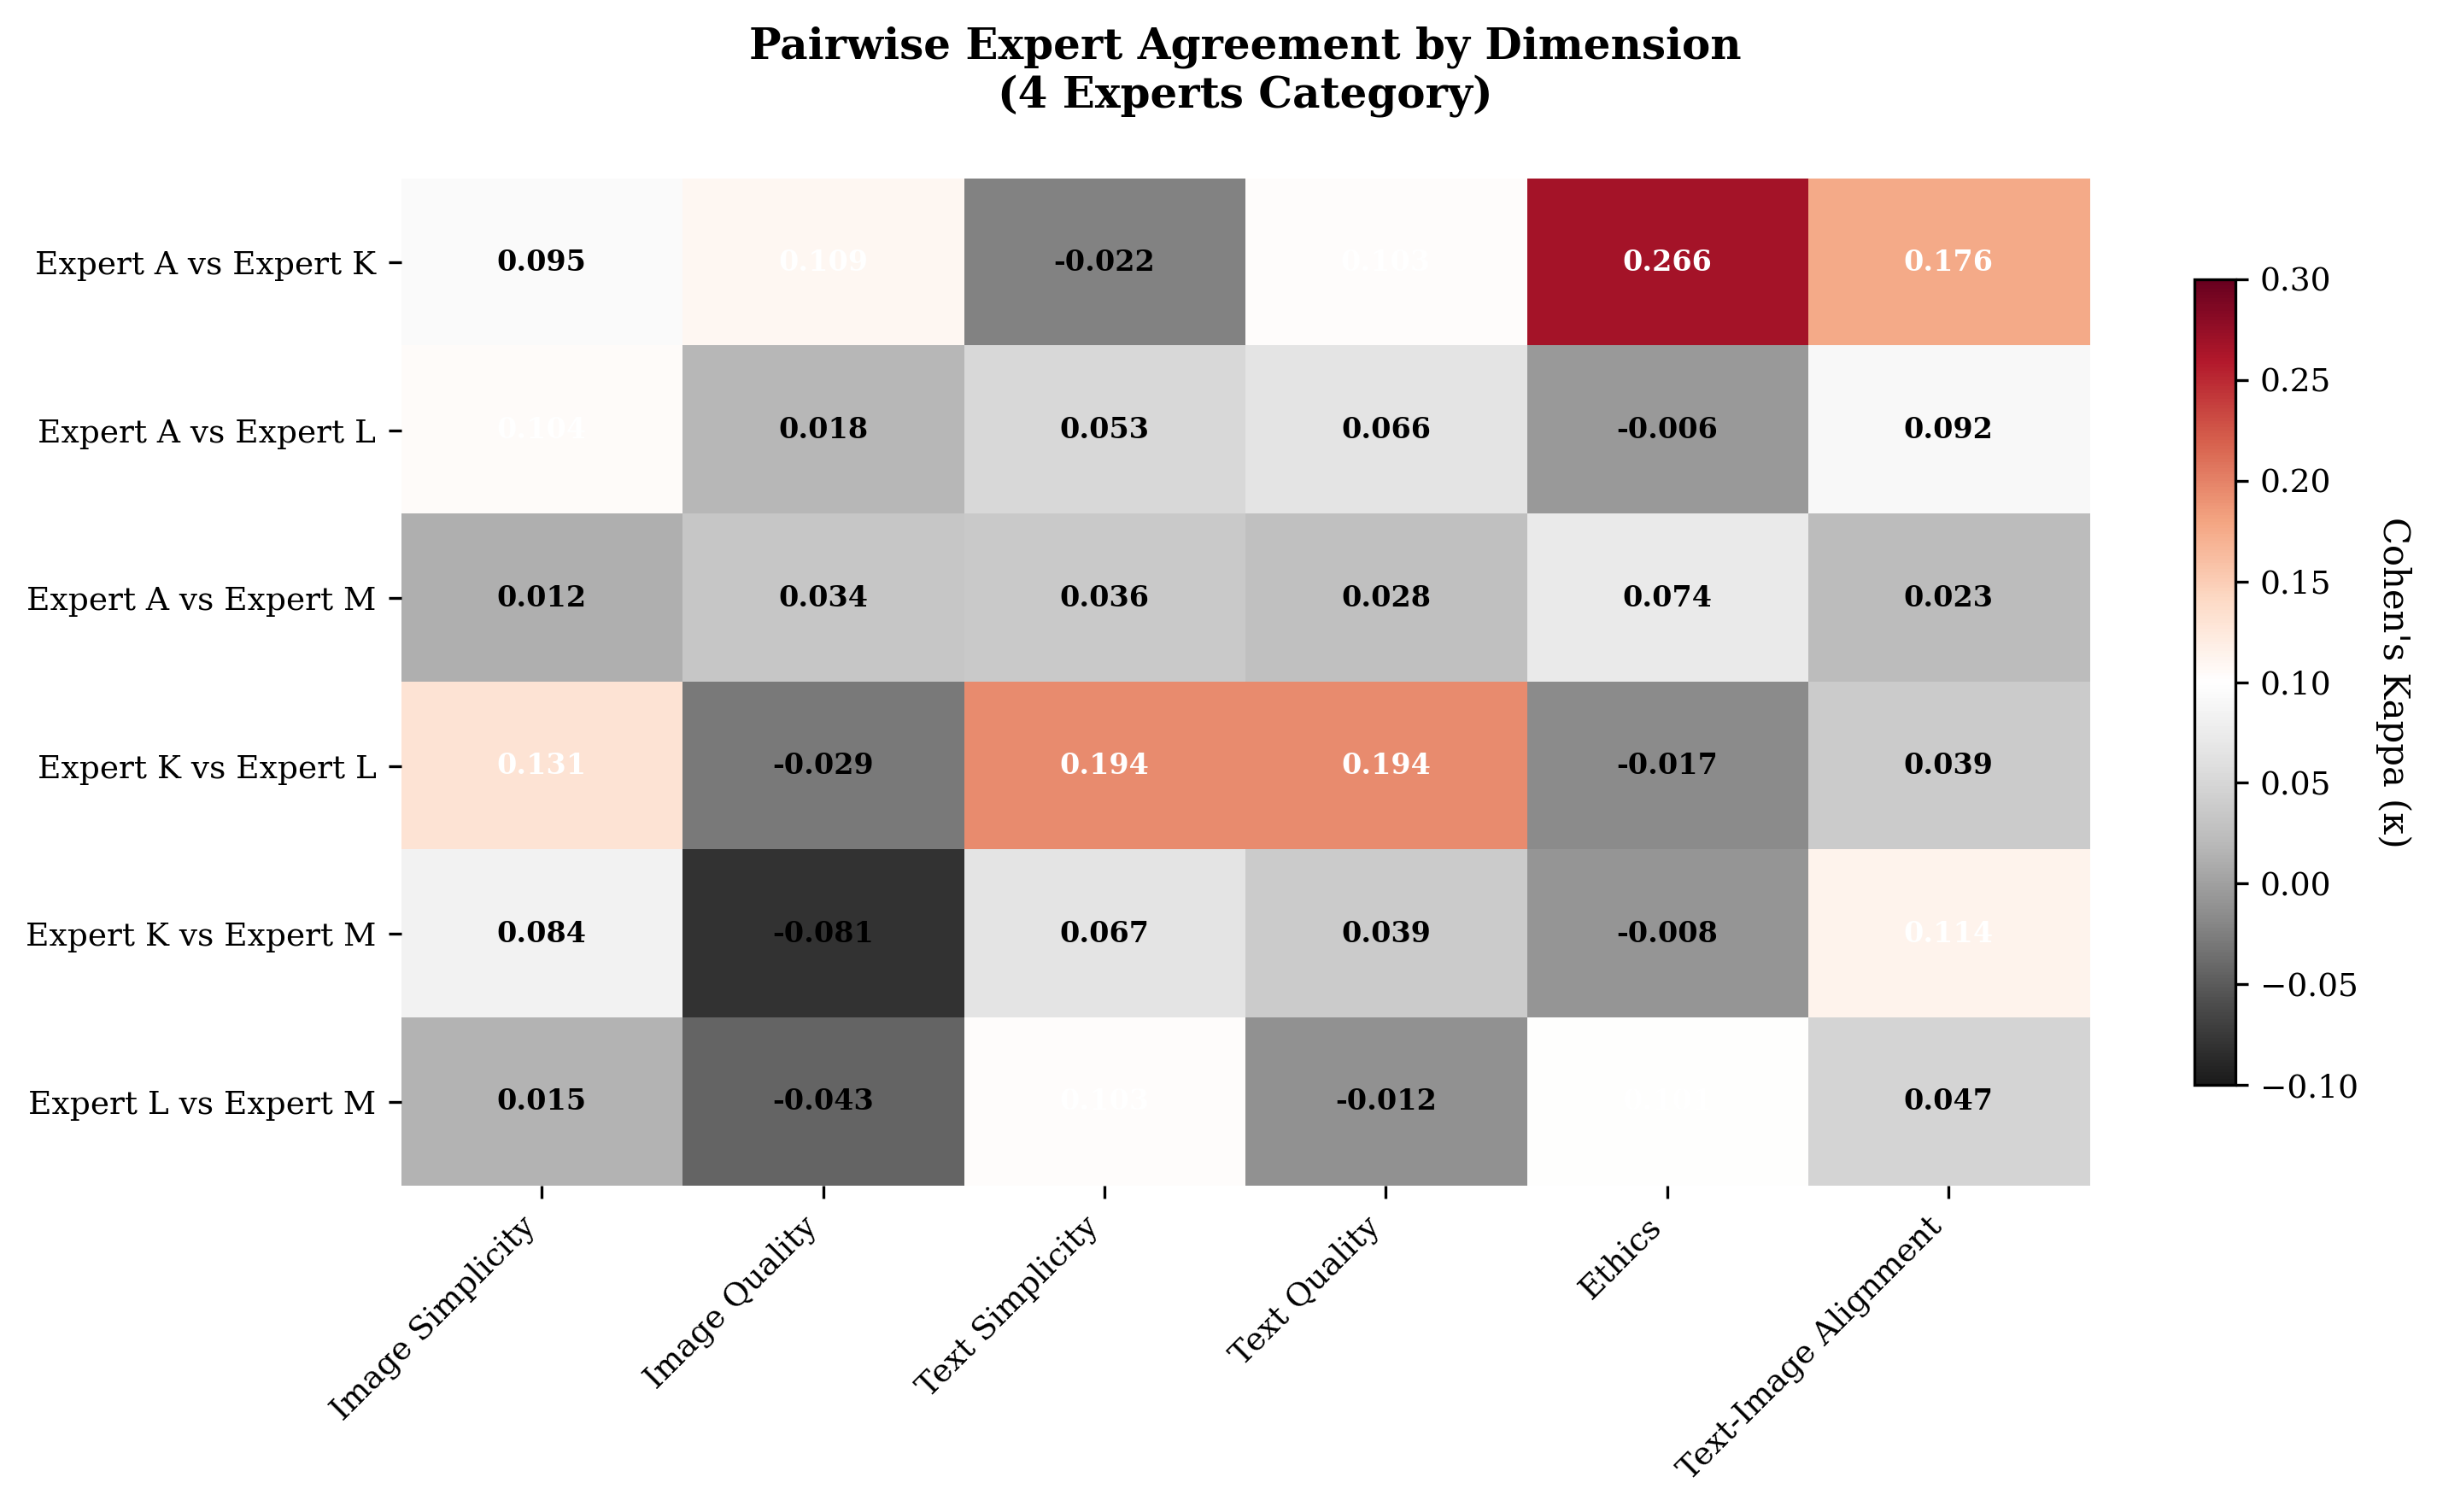

4. Creating dimension comparison...


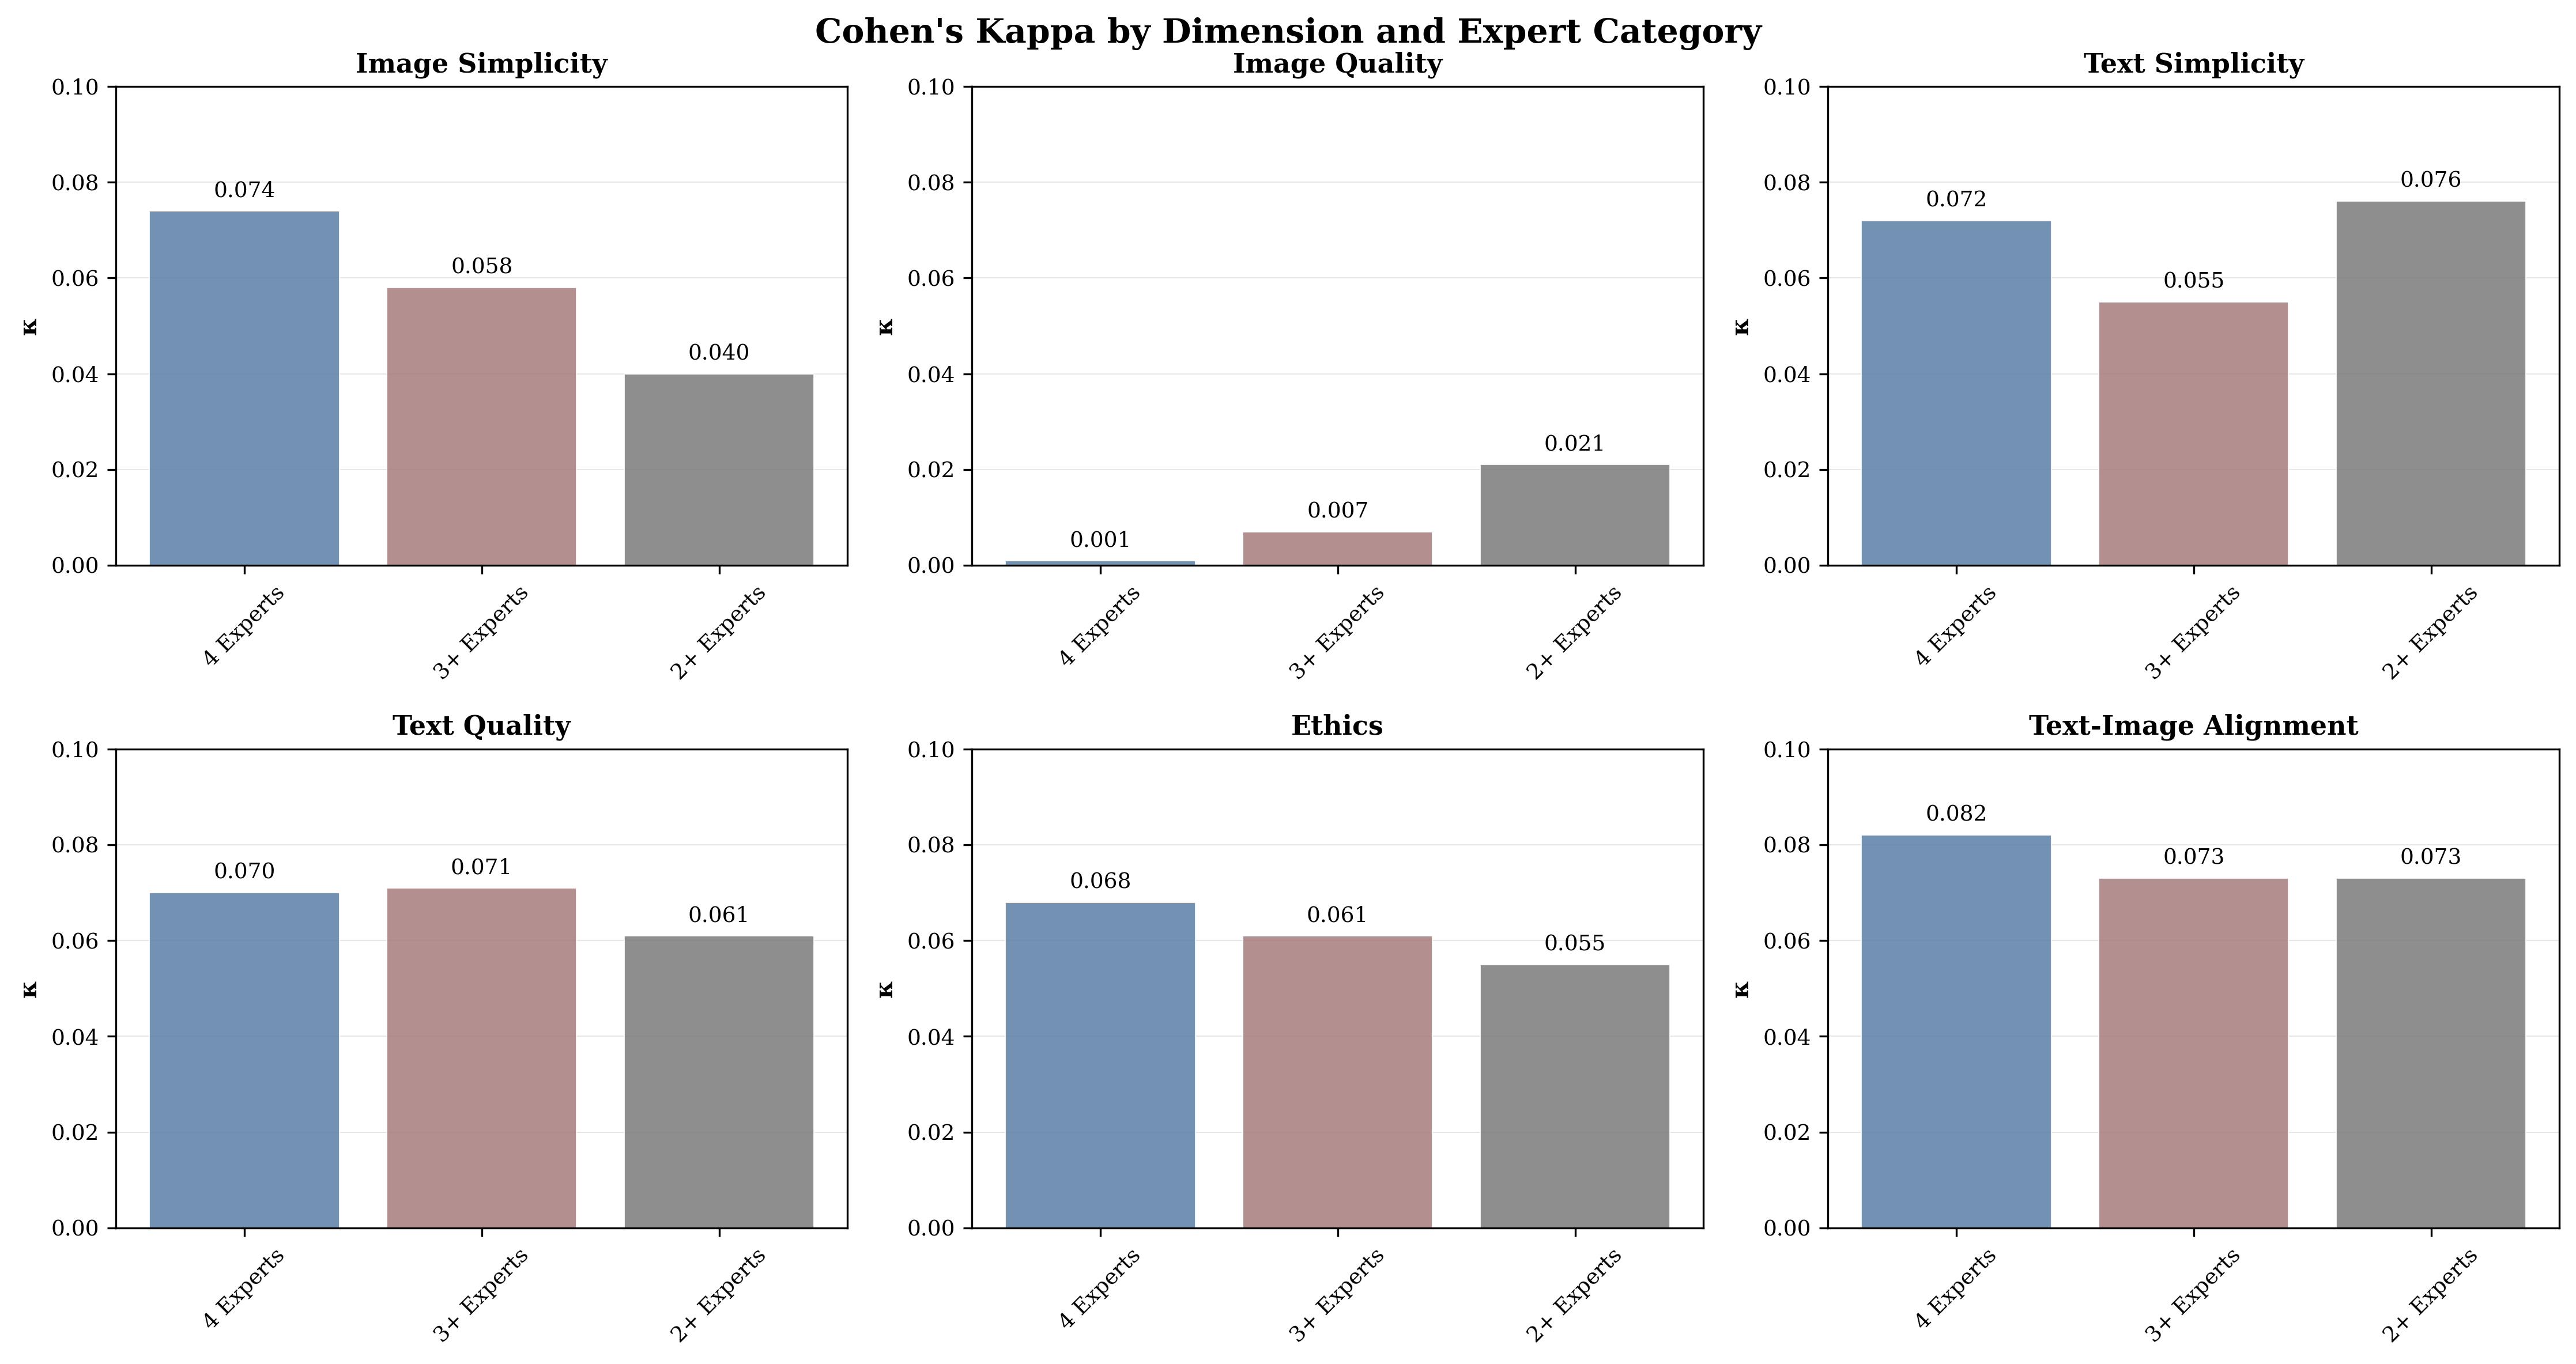

5. Creating summary statistics...


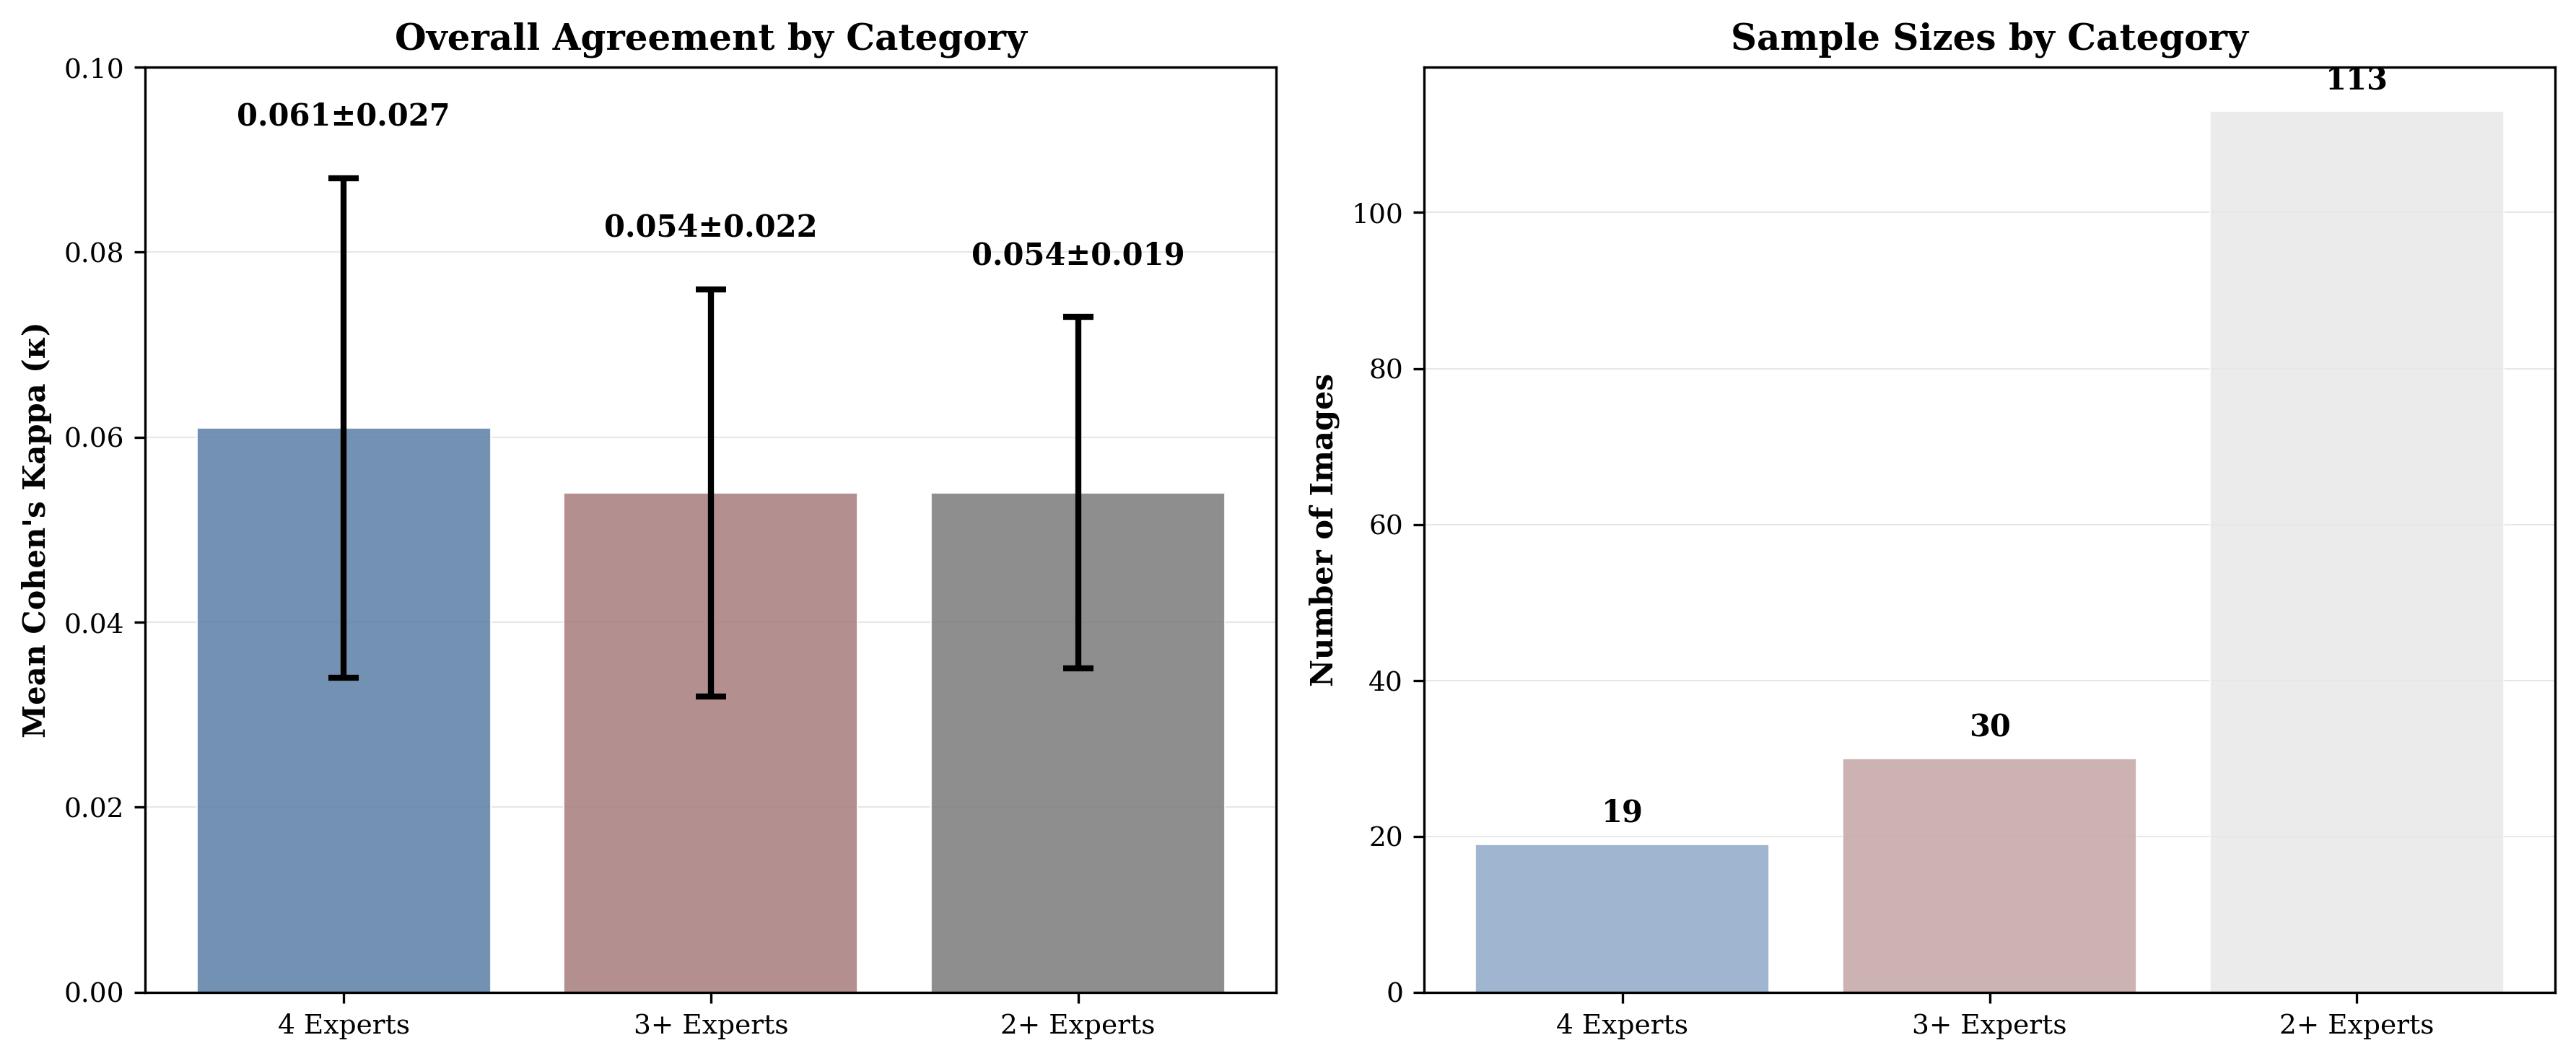

All visualizations created successfully!
Files saved with 300 DPI resolution for publication quality.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Set style parameters for publication-quality figures
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 14,
    'font.family': 'serif',
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.0
})

# Define elegant, muted color scheme for publication
colors = {
    'primary_blue': '#5B7FA6',      # Muted steel blue
    'primary_red': '#A67C7C',       # Muted dusty rose  
    'light_blue': '#8FA8C7',        # Light muted blue
    'light_red': '#C4A5A5',         # Light muted rose
    'dark_blue': '#4A6B8A',         # Dark muted blue
    'dark_red': '#8B6B6B',          # Dark muted rose
    'gray': '#7A7A7A',              # Professional gray
    'light_gray': '#E8E8E8',        # Very light gray
    'accent': '#6B8E6B',            # Muted sage green
    'neutral': '#9B9B9B'            # Neutral medium gray
}

def create_kappa_summary_data():
    """Create the kappa data from your results"""
    data = {
        '4 Experts': {
            'Image Simplicity': 0.074,
            'Image Quality': 0.001, 
            'Text Simplicity': 0.072,
            'Text Quality': 0.070,
            'Ethics': 0.068,
            'Text-Image Alignment': 0.082
        },
        '3+ Experts': {
            'Image Simplicity': 0.058,
            'Image Quality': 0.007,
            'Text Simplicity': 0.055, 
            'Text Quality': 0.071,
            'Ethics': 0.061,
            'Text-Image Alignment': 0.073
        },
        '2+ Experts': {
            'Image Simplicity': 0.040,
            'Image Quality': 0.021,
            'Text Simplicity': 0.076,
            'Text Quality': 0.061, 
            'Ethics': 0.055,
            'Text-Image Alignment': 0.073
        }
    }
    return data

def create_kappa_heatmap(data, save_path=None):
    """Create an elegant heatmap of Cohen's Kappa values"""
    
    # Convert data to DataFrame for easier plotting
    df = pd.DataFrame(data).T
    
    # Create figure with tight layout
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Create heatmap with custom colormap
    mask = df.isnull()
    
    # Use a subtle, elegant colormap
    cmap = plt.cm.Blues  # Much more elegant than RdYlBu_r
    
    # Create heatmap with muted colors
    im = ax.imshow(df.values, cmap=cmap, aspect='auto', vmin=0, vmax=0.1)
    
    # Set ticks and labels
    ax.set_xticks(range(len(df.columns)))
    ax.set_yticks(range(len(df.index)))
    ax.set_xticklabels(df.columns, rotation=45, ha='right')
    ax.set_yticklabels(df.index)
    
    # Add value annotations with better contrast
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.iloc[i, j]
            ax.text(j, i, f'{value:.3f}', ha='center', va='center', 
                   color='white' if value > 0.04 else 'black', fontweight='bold', fontsize=9)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Cohen\'s Kappa (κ)', rotation=270, labelpad=15)
    
    # Add interpretation reference lines
    ax.axhline(y=-0.5, color='black', linewidth=0.8)
    ax.axvline(x=-0.5, color='black', linewidth=0.8)
    
    # Add title and improve layout
    ax.set_title('Inter-Annotator Agreement by Category and Dimension', 
                fontweight='bold', pad=20)
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

def create_kappa_bar_chart(data, save_path=None):
    """Create grouped bar chart of Cohen's Kappa values"""
    
    # Prepare data
    categories = list(data.keys())
    dimensions = list(data['4 Experts'].keys())
    
    # Set up the plot
    x = np.arange(len(dimensions))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create bars for each category with elegant muted colors
    bars1 = ax.bar(x - width, [data['4 Experts'][dim] for dim in dimensions], 
                   width, label='4 Experts', color=colors['primary_blue'], alpha=0.85, edgecolor='white', linewidth=0.5)
    bars2 = ax.bar(x, [data['3+ Experts'][dim] for dim in dimensions], 
                   width, label='3+ Experts', color=colors['primary_red'], alpha=0.85, edgecolor='white', linewidth=0.5)
    bars3 = ax.bar(x + width, [data['2+ Experts'][dim] for dim in dimensions], 
                   width, label='2+ Experts', color=colors['gray'], alpha=0.85, edgecolor='white', linewidth=0.5)
    
    # Customize the plot
    ax.set_xlabel('Evaluation Dimensions', fontweight='bold')
    ax.set_ylabel('Cohen\'s Kappa (κ)', fontweight='bold')
    ax.set_title('Inter-Annotator Agreement Across Dimensions and Categories', 
                fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(dimensions, rotation=45, ha='right')
    
    # Add subtle interpretation reference lines
    ax.axhline(y=0.2, color=colors['accent'], linestyle='--', alpha=0.6, linewidth=1)
    ax.axhline(y=0.4, color=colors['accent'], linestyle='--', alpha=0.6, linewidth=1)
    ax.axhline(y=0.6, color=colors['accent'], linestyle='--', alpha=0.6, linewidth=1)
    
    # Add subtle interpretation labels
    ax.text(0.02, 0.02, 'Poor-Slight', transform=ax.transAxes, 
           bbox=dict(boxstyle='round,pad=0.3', facecolor=colors['light_gray'], alpha=0.8), fontsize=8)
    ax.text(0.02, 0.22, 'Fair', transform=ax.transAxes,
           bbox=dict(boxstyle='round,pad=0.3', facecolor=colors['light_gray'], alpha=0.8), fontsize=8)
    ax.text(0.02, 0.42, 'Moderate', transform=ax.transAxes,
           bbox=dict(boxstyle='round,pad=0.3', facecolor=colors['light_gray'], alpha=0.8), fontsize=8)
    ax.text(0.02, 0.62, 'Substantial', transform=ax.transAxes,
           bbox=dict(boxstyle='round,pad=0.3', facecolor=colors['light_gray'], alpha=0.8), fontsize=8)
    
    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    
    # Customize legend
    ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    # Set grid
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)
    
    # Set y-axis limits
    ax.set_ylim(0, 0.1)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

def create_expert_pair_heatmap(save_path=None):
    """Create heatmap showing agreement between expert pairs"""
    
    # Sample data from your results - you can replace with actual pairwise data
    expert_pairs_data = {
        'Expert A vs Expert K': [0.095, 0.109, -0.022, 0.103, 0.266, 0.176],
        'Expert A vs Expert L': [0.104, 0.018, 0.053, 0.066, -0.006, 0.092],
        'Expert A vs Expert M': [0.012, 0.034, 0.036, 0.028, 0.074, 0.023],
        'Expert K vs Expert L': [0.131, -0.029, 0.194, 0.194, -0.017, 0.039],
        'Expert K vs Expert M': [0.084, -0.081, 0.067, 0.039, -0.008, 0.114],
        'Expert L vs Expert M': [0.015, -0.043, 0.103, -0.012, 0.101, 0.047]
    }
    
    dimensions = ['Image Simplicity', 'Image Quality', 'Text Simplicity', 
                  'Text Quality', 'Ethics', 'Text-Image Alignment']
    
    # Create DataFrame
    df = pd.DataFrame(expert_pairs_data, index=dimensions).T
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create elegant heatmap with muted colors
    im = ax.imshow(df.values, cmap='RdGy_r', aspect='auto', vmin=-0.1, vmax=0.3)
    
    # Set ticks and labels
    ax.set_xticks(range(len(df.columns)))
    ax.set_yticks(range(len(df.index)))
    ax.set_xticklabels(df.columns, rotation=45, ha='right')
    ax.set_yticklabels(df.index)
    
    # Add value annotations
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.iloc[i, j]
            color = 'white' if abs(value) > 0.1 else 'black'
            ax.text(j, i, f'{value:.3f}', ha='center', va='center', 
                   color=color, fontweight='bold', fontsize=8)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Cohen\'s Kappa (κ)', rotation=270, labelpad=15)
    
    # Add title
    ax.set_title('Pairwise Expert Agreement by Dimension\n(4 Experts Category)', 
                fontweight='bold', pad=20)
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

def create_dimension_comparison(data, save_path=None):
    """Create comparison of dimensions across categories"""
    
    # Prepare data for plotting
    dimensions = list(data['4 Experts'].keys())
    categories = list(data.keys())
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, dim in enumerate(dimensions):
        ax = axes[i]
        
        # Get values for this dimension
        values = [data[cat][dim] for cat in categories]
        
        # Create bar chart with muted colors
        bars = ax.bar(categories, values, 
                     color=[colors['primary_blue'], colors['primary_red'], colors['gray']], 
                     alpha=0.85, edgecolor='white', linewidth=0.5)
        
        # Customize subplot
        ax.set_title(dim, fontweight='bold', fontsize=11)
        ax.set_ylabel('κ', fontweight='bold')
        ax.set_ylim(0, 0.1)
        
        # Add value labels
        for bar, value in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2., value + 0.002,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)
        
        # Add grid
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_axisbelow(True)
        
        # Rotate x-labels if needed
        ax.tick_params(axis='x', rotation=45)
    
    plt.suptitle('Cohen\'s Kappa by Dimension and Expert Category', 
                fontweight='bold', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

def create_summary_statistics_plot(save_path=None):
    """Create summary statistics visualization"""
    
    # Data from your results
    categories = ['4 Experts', '3+ Experts', '2+ Experts']
    means = [0.061, 0.054, 0.054]
    stds = [0.027, 0.022, 0.019]
    sample_sizes = [19, 30, 113]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Mean kappa with error bars - elegant muted colors
    bars1 = ax1.bar(categories, means, yerr=stds, capsize=5,
                    color=[colors['primary_blue'], colors['primary_red'], colors['gray']], 
                    alpha=0.85, error_kw={'linewidth': 2, 'capthick': 2}, 
                    edgecolor='white', linewidth=0.5)
    
    ax1.set_title('Overall Agreement by Category', fontweight='bold')
    ax1.set_ylabel('Mean Cohen\'s Kappa (κ)', fontweight='bold')
    ax1.set_ylim(0, 0.1)
    
    # Add value labels
    for bar, mean, std in zip(bars1, means, stds):
        ax1.text(bar.get_x() + bar.get_width()/2., mean + std + 0.005,
                f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_axisbelow(True)
    
    # Plot 2: Sample sizes with lighter, muted colors
    bars2 = ax2.bar(categories, sample_sizes,
                    color=[colors['light_blue'], colors['light_red'], colors['light_gray']], 
                    alpha=0.85, edgecolor='white', linewidth=0.5)
    
    ax2.set_title('Sample Sizes by Category', fontweight='bold')
    ax2.set_ylabel('Number of Images', fontweight='bold')
    
    # Add value labels
    for bar, size in zip(bars2, sample_sizes):
        ax2.text(bar.get_x() + bar.get_width()/2., size + 2,
                f'{size}', ha='center', va='bottom', fontweight='bold')
    
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_axisbelow(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

# Main execution
if __name__ == "__main__":
    # Create the data
    kappa_data = create_kappa_summary_data()
    
    print("Creating Cohen's Kappa visualizations...")
    print("=" * 50)
    
    # Create all visualizations
    print("1. Creating summary heatmap...")
    create_kappa_heatmap(kappa_data, 'kappa_heatmap.png')
    
    print("2. Creating grouped bar chart...")
    create_kappa_bar_chart(kappa_data, 'kappa_barchart.png')
    
    print("3. Creating expert pair heatmap...")
    create_expert_pair_heatmap('expert_pairs_heatmap.png')
    
    print("4. Creating dimension comparison...")
    create_dimension_comparison(kappa_data, 'dimension_comparison.png')
    
    print("5. Creating summary statistics...")
    create_summary_statistics_plot('summary_statistics.png')
    
    print("=" * 50)
    print("All visualizations created successfully!")
    print("Files saved with 300 DPI resolution for publication quality.")